In [192]:
# 1:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import matplotlib
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal
import csv
import datetime
import pandas as pd
import datetime
import pandas as pd
import numpy as np
import ast
import time
import math
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from operator import itemgetter 

In [2]:
global simworldname
global groundtruth
global motion_readings
global my_map
global grid_map
global datasetname
global distances
global oracle
global analyzer
global dataset_times
global dataset_readings
global dataset
global motions_order
global motion_sensors
global motions_sensor_data
global simulated_sensor_readings
global agentsnum
global sensors_list
global sr_matrix
global indices_to_keep
global gtx
global gty
global rsr
global df_
global gtt
global human_readable_sensor_array
global sensed_areas
global plotflag
global syntheticTrace

In [3]:
agentsnum = 1
plotflag = False
sensed_areas = {}
human_readable_sensor_array = []
gtt = []
gtx = []
gty = []
rsr = []
indices_to_keep = [0, 1, 2, 3, 4, 5, 11, 15, 16, 17, 18, 19, 20, 21]
simworldname = 'Data//simulationWorld2.xml' #ENVIROMENT
# groundtruth = 'Data//28jun2.csv' #AGENT'S MOVEMENTS

motion_readings = 'Data//Sensor Readings//28Jun2_events.txt'
syntheticTrace = 'Data//Synthetic Agent Traces//AgentTrace_28Jun2.csv'
# syntheticTrace2 = 'Data//Synthetic Agent Traces//AgentTrace_6Ju14p.csv'
UltimateDatasetName = "Data//Results//Ultimate_Dataset_28Jun2"
FirstDatasetName = 'Data//Pandas Datasets//Dataset_28Jun2'
# groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []
dataset_times = []
dataset_readings = []
dataset = ['time', 'gt(x)', 'gt(y)', 'motion_readings']

motions_order = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
motions_sensor_data = {}
simulated_sensor_readings = []
sensors_list = []
sr_matrix = np.zeros([1, 14])
df_ = (pd.read_csv(FirstDatasetName + ".csv"))

templist = []
for i in range(0, len(df_)):
    templist.append(ast.literal_eval(df_.gt_motion_readings[i]))
    
df_.gt_motion_readings = templist

In [4]:
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    current_location = Localizer(pythonTimer.time()).run(event)
    return current_location
    
# 2:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    # print(value - array[idx])
    return idx

In [5]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()
    r = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = str(660 - int(str(element.find('point').find('xcoord').text)))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text)).replace('sensor','')
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        # print("real: ", real_localization)
        # print("simu: ", simulated_localization)
              
        return probCdf
    
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        # self.sensing_area = (str(radius))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist    

#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))
    
class GridMap:
    map = ""

In [6]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

def ParseSimulationWorld():
    root = xml.etree.ElementTree.parse(simworldname).getroot()

    grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
    grid2 = np.copy(grid_map)

    for element in root:
        if(element.tag == 'sensors'):
            for sensor in element:
                #Choose the kind of sensor we have
                if(str(sensor.find('type').text) == 'RFID_Reader'):
                    # this_sensor = RFID_Reader(sensor)
                    continue

                if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                    # this_sensor = MotionSensorBinary(sensor, radius)
                    this_sensor = MotionSensorBinary(sensor)

                if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                    this_sensor = MotionSensorAnalog(sensor)

                if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                    # this_sensor = PressureSensorAnalog(sensor)
                    continue

                if(str(sensor.find('type').text) == 'BeaconSensor'):
                    #this_sensor = BeaconSensor(sensor)
                    continue

                sensors_list.append(this_sensor)
                # print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y + " " + this_sensor.sensor_id)

In [7]:
############################################
####         LOCALIZATION CLASS         ####
############################################
class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                current_location = self.localize(timestamp, event)
    
        return current_location
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                                 
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):   
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])

        except:
            print("start!")
                
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    circ = Circle((int(float(sensor.x)/10), int(float(sensor.y)/10)), int(float(sensor.sensing_area)/10))
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
            
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)
        
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist)
        
        return self.AskLocationFromLocalizer(grid_map)
        
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
                
        return np.linalg.norm(inferred_location - real_location)
            
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == time)], axis = 0)
        # print("ponto: ", point, "time: ", time)
        return point
    
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors

In [291]:
def SimulateSensorReading(fs):
    sensor_bins = [0] * 14
    if len(fs) == 0:
        simulated_sensor_readings.append(sensor_bins)
    
    else:
        for sensor in fs:
            if (sensor.sensor_type == 'MotionSensorBinary'):
                snum = int(sensor.sensor_id.replace('sensor',''))
                sensor_bins[motion_sensors.index(snum)] = 1

        simulated_sensor_readings.append(sensor_bins)
        
        if (len(simulated_sensor_readings) % 100 == 0):
            print(len(simulated_sensor_readings))

def FilterOutlierSensorReadings(i, current_location):
    epsilon = 2/(1 + math.exp(i / len(df_))) + 1.5
    for sensor in sensors_list:
        snum = int(sensor.sensor_id.replace('sensor',''))
        circ = Circle((current_location[0], current_location[1]), epsilon)
        
        if (not circ.contains_point([float(int(sensor.x) / 10), float(int(sensor.y) / 10)])):
            if (df_.gt_motion_readings[i][motion_sensors.index(snum)]):
                if (sensor.sensor_type == 'MotionSensorBinary'):
                    snum = int(sensor.sensor_id.replace('sensor',''))
                    df_.gt_motion_readings[i][motion_sensors.index(snum)] = 0
                    print("we got an outlier!   ", df_.gt_motion_readings[i])

            
def readFileCSV():             
    for i in range(1, len(df_)):     
        myfs = []
        no_event_flag = 1
        xtrace = df_.gtx[i]
        ytrace = df_.gty[i]
        x = abs(float(xtrace)) * 10
        y = abs(float(ytrace)) * 10
        loc = [x, y]
        
        if (agentsnum == 2):
            xtrace2 = df_.gtx2[i]
            ytrace2 = df_.gty2[i]
            x2 = abs(float(xtrace2)) * 10
            y2 = abs(float(ytrace2)) * 10
            loc = [x2, y2]

        # print(loc)
        timetoadd = df_.time[i]
        
        # if loc not in oracle['location'] and timetoadd not in oracle['time']:
        oracle['location'].append(loc)
        oracle['time'].append(timetoadd) 
            # print(oracle)
        
        for sensor in sensors_list:
            if (plotflag):
                pp = ax.plot(int(sensor.x) / 100, int(sensor.y) / 100 , marker='.', color='k', lw=5)
                
            if (sensor.sensor_type == "MotionSensorBinary"):    
                circ = Circle((float(int(sensor.x) / 10), float(int(sensor.y) / 10)), float(int(sensor.sensing_area) / 10))
                if (circ.contains_point([x, y])):
                    no_event_flag = 0
                    event = Event()
                    event.sensor = sensor.sensor_id #SensorId that created the event
                    event.data = "TRUE"  #data
                    event.hash = "|hash|" #hash
                    event.source = "xmlFile" #where is coming from
                    event.timestamp = timetoadd
                    event.sensorType = sensor.sensor_type #type of sensor
                        
                    # print("synthetic sensor:", int(sensor.x) / 10, int(sensor.y) / 10)
                    
                    if (plotflag):
                        p3 = ax.plot(float(int(sensor.x) / 100), float(int(sensor.y) / 100) , marker='>', color='r', lw=10)
                    
                    current_location = run_localization(event)
                    FilterOutlierSensorReadings(i, current_location)
                    myfs.append(sensor)
                
                if (agentsnum == 2):
                    if (circ.contains_point([x2, y2])):
                        no_event_flag = 0
                        event = Event()
                        event.sensor = sensor.sensor_id #SensorId that created the event
                        event.data = "TRUE"  #data
                        event.hash = "|hash|" #hash
                        event.source = "xmlFile" #where is coming from
                        event.timestamp = timetoadd
                        event.sensorType = sensor.sensor_type #type of sensor

                        # print("synthetic sensor:", int(sensor.x) / 10, int(sensor.y) / 10)

                        if (plotflag):
                            p3 = ax.plot(float(int(sensor.x) / 100), float(int(sensor.y) / 100) , marker='>', color='r', lw=10)

                        current_location = run_localization(event)
                        FilterOutlierSensorReadings(df_, i, current_location)
                        myfs.append(sensor)


                
        real_fired = [ii for ii, e in enumerate(df_.gt_motion_readings[i]) if e == 1]

        for rf in real_fired:
            sid = str(motion_sensors[rf])
            sensed_areas[sid].append((df_.gtx[i], df_.gty[i]))

            for s in sensors_list:
                if (s.sensor_id == sid):
                    # print(sid, df_.gtx[i], df_.gty[i])
                    sensed_areas[s.sensor_id].append((df_.gtx[i], df_.gty[i]))
                    if (plotflag):
                        p4 = ax.plot(float(int(s.x) / 100), float(int(s.y) / 100) , marker='<', color='b', lw=5)

        no_event_flag = 0
        
        SimulateSensorReading(myfs) 
        
        if (plotflag):
            xlim=(0, 6)
            ylim=(0, 10)
            p1 = ax.plot(df_.gtx[i], df_.gty[i], marker='+', color='k', lw=10)
            
            if (agentsnum == 2):
                p4 = ax.plot(df_.gtx2[i], df_.gty2[i], marker='+', color='b', lw=10)
            
            plt.xlim(*xlim)
            plt.ylim(*ylim)
            plt.gca().invert_yaxis()
            plt.show()
            fig.canvas.draw()
            ax.cla()
            ax.imshow(img, extent=[0, 6, 0, 10])
# 9:

def CreateUltilmateDataset():
    simulated_sensor_readings.append([0]*14)
    df_.synthetic_motion_readings = simulated_sensor_readings[0: len(df_.gtx)]
    df_.to_csv(UltimateDatasetName + ".csv", sep=',', index=False)

def smoothListGaussian(list,strippedXs=False,degree=15):  
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)  

    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    
    for i in range(len(smoothed)):  
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
        if (smoothed[i] < 0.1):
            smoothed[i] = 0
    
    return smoothed      
  
def GMMBuilder(X, T, TotalT):    
    X = np.asarray(X)
    T = np.asarray(T)
    TotalT = np.asarray(TotalT)
    
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)
    TotalT = TotalT.reshape(-1, 1)
    
    N = np.arange(1, 19)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(T)

    # compute the AIC and the BIC
    AIC = [m.aic(T) for m in models]
    BIC = [m.bic(T) for m in models]
    
    M_best = models[np.argmin(BIC)]
    
    # plot 2: data + best-fit mixture
    fig, ax = plt.subplots(figsize = (10, 5))
    

    x = np.linspace(T[0], T[len(T) - 1], len(T))
    
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture", ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    
    return M_best

def PrintingData(df):
    from scipy.interpolate import spline
    %matplotlib inline
    gt_readings = {}

    time_list_formatted = [time.strftime('%H:%M:%S', time.localtime(x)) for x in df_.time]
    
    for sensor in range(0, 14):
        gt_readings[sensor] = []
        for i in range(0, len(df['gt_motion_readings'])):
            gt_readings[sensor].append(df['gt_motion_readings'][i][sensor])

    sim_readings = {}

    for sensor in range(0, 14):
        sim_readings[sensor] = []
        for i in range(0, len(df_['synthetic_motion_readings'])):
            sim_readings[sensor].append(df['synthetic_motion_readings'][i][sensor])

    for i in range(len(gt_readings)): 
        look_up_id = motion_sensors[i]
    
        for j in range(0, len(sensors_list)):
            if (int(sensors_list[j].sensor_id) == look_up_id):
                thissensor = sensors_list[j]

        poly_gt = np.poly1d(np.polyfit(list(range(0,len(gt_readings[i]))), gt_readings[i],1))(gt_readings[i])        
        poly_sim = np.poly1d(np.polyfit(list(range(0,len(sim_readings[i]))), sim_readings[i] ,1))(sim_readings[i])
        
        s_gt = smoothListGaussian(gt_readings[i])
        s_gt_nonzeros = [i for i, e in enumerate(s_gt) if e != 0]
        s_gt_zeros = [i for i, e in enumerate(s_gt) if e == 0]
                
        if (len(s_gt_nonzeros) > 0):
            GMM_model = GMMBuilder(itemgetter(*s_gt_nonzeros)(s_gt), itemgetter(*s_gt_nonzeros)(df_.time), df_.time)
        
        
        
        # print("SIM")
        # s_sim = smoothListGaussian(sim_readings[i])
        
        
        
        # print(thissensor.sensor_id, thissensor.x, thissensor.y)
        # xticks(np.arange(12), df_.times, rotation=90)
        plt.figure(figsize=(10,6))
        plt.plot(list(range(0,len(s_gt))),s_gt , label='Real Sensor Readings')
        # plt.plot(list(range(0,len(s_sim))), s_sim, label='Synthetic Sensor Readings')
        plt.xticks(np.arange(0, len(time_list_formatted), step=100), time_list_formatted[::100])
        plt.xticks(rotation=90)
        plt.legend()
        plt.show()

    # plt.tight_layout()

In [1]:
from IPython.display import Javascript

Javascript("Jupyter.notebook.execute_cells([0, 1, 2, 3, 4, 5, 6, 7])")

<IPython.core.display.Javascript object>

In [9]:
radius_array = [70]

global fig
global ax

if (plotflag):
    %matplotlib notebook
    fig, ax = plt.subplots(figsize = (6, 10))
    # plt.ion()
    # fig = plt.figure()
    # plt.figure()
    img = plt.imread("Data//sc.png")
    # fig, ax = plt.subplots(figsize=(5, 10))
    # ax.imshow(img, extent=[0, 7, 0, 11])

for r in radius_array:
    # RestartVariables()
    #ParseSimulationWorld(r)
    ParseSimulationWorld()
    
    for s in sensors_list:
        sensed_areas[s.sensor_id] = []

    readFileCSV()
    
    print("------------radius change")
    print(r)

start!
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
100
200
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an outlier!    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
we got an 

GT
[20.99672251  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 20.99672251]


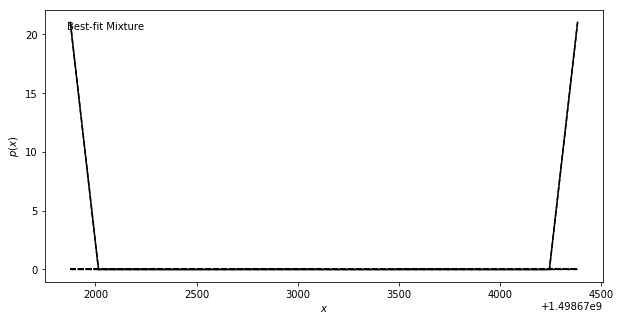

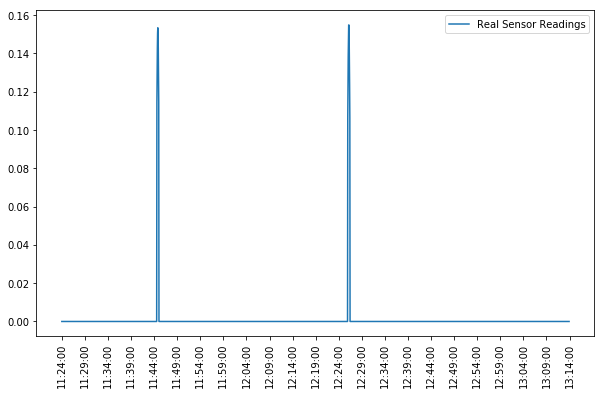

GT


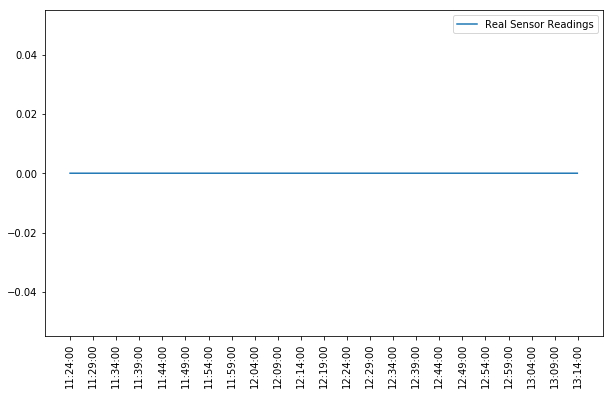

GT


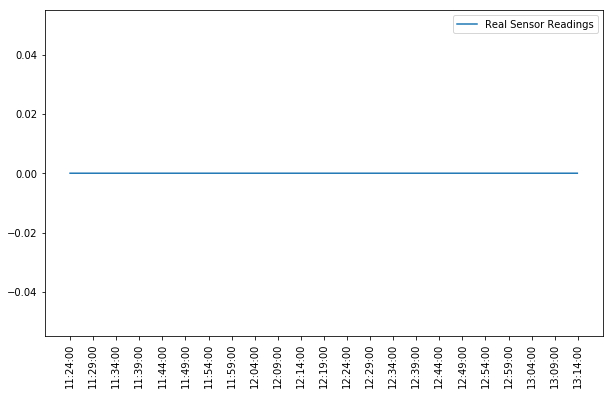

GT


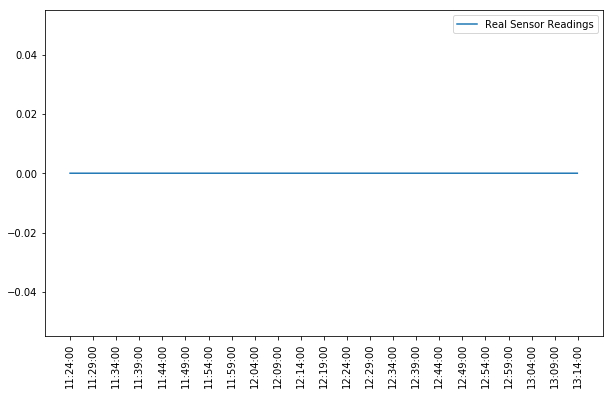

GT
[1.78546148e-03 3.89914389e-03 5.78290707e-03 5.82480402e-03
 3.98450682e-03 1.85108348e-03 5.84030565e-04 1.25142071e-04
 1.82108083e-05 1.79975469e-06 1.20796840e-07 5.50625013e-09
 1.70456879e-10 3.58373721e-12 5.54921795e-14 3.71932708e-13
 2.18083006e-11 8.69809509e-10 2.35606881e-08 4.33418490e-07
 5.41479597e-06 4.59422128e-05 2.64726164e-04 1.03594564e-03
 2.75316493e-03 4.96915588e-03 6.09099580e-03 5.07049264e-03
 2.86667050e-03 1.10103403e-03 2.88775064e-04 5.76018846e-05
 2.89323441e-05 6.86633968e-05 1.80735317e-04 4.25186526e-04
 8.87892173e-04 1.64559180e-03 2.70686670e-03 3.95185537e-03
 5.12081316e-03 5.88995364e-03 6.01439796e-03 5.45452014e-03
 4.39810934e-03 3.16229825e-03 2.04524546e-03 1.22172995e-03
 7.27276712e-04 5.07984523e-04 4.84102623e-04 5.91003184e-04
 7.91180720e-04 1.06866606e-03 1.41856309e-03 1.83838794e-03
 2.32265508e-03 2.86002378e-03 3.43218331e-03 4.01405935e-03
 4.57518955e-03 5.08213637e-03 5.50168159e-03 5.80438891e-03
 5.96800897e-03 5.980

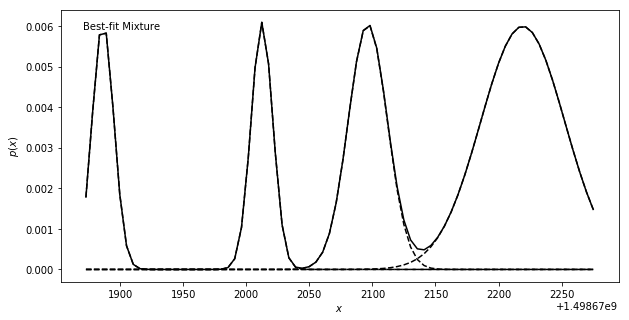

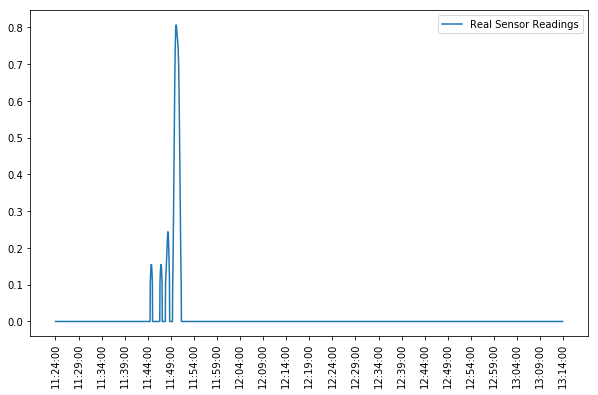

GT
[0.00079634 0.00085465 0.00091542 0.00097858 0.00104403 0.00111166
 0.00118134 0.00125291 0.00132619 0.00140099 0.00147709 0.00155426
 0.00163224 0.00171075 0.00178952 0.00186823 0.00194657 0.00202421
 0.00210082 0.00217606 0.00224958 0.00232104 0.0023901  0.00245641
 0.00251966 0.00257952 0.0026357  0.0026879  0.00273587 0.00277936
 0.00281816 0.00285209 0.00288097 0.00290471 0.00292319 0.00293637
 0.00294423 0.0029468  0.00294412 0.00293629 0.00292344 0.00290575
 0.00288341 0.00285666 0.00282578 0.00279106 0.00275283 0.00271144
 0.00266727 0.00262071 0.00257218 0.0025221  0.00247091 0.00241904
 0.00236693 0.00231503 0.00226378 0.0022136  0.00216491 0.00211812
 0.00207361 0.00203175 0.00199287 0.00195729 0.0019253  0.00189716
 0.00187308 0.00185327 0.00183788 0.00182702 0.00182079 0.00181922
 0.00182232 0.00183006 0.00184239 0.00185918 0.00188031 0.0019056
 0.00193484 0.00196779 0.00200419 0.00204374 0.00208612 0.00213099
 0.00217797 0.00222668 0.00227674 0.00232772 0.00237922 0.00

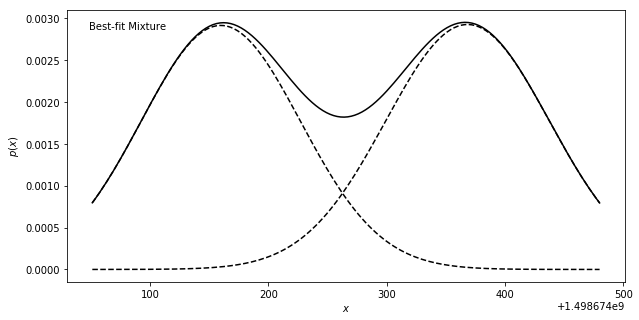

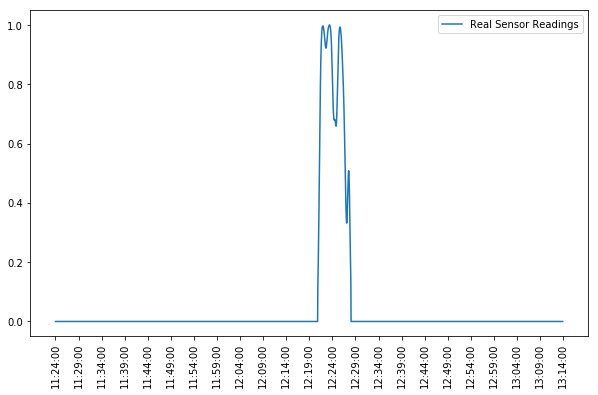

GT
[1.19490070e-002 1.47754714e+001 1.47754834e+001 1.15296913e-002
 1.01812807e-002 1.08670141e-002 1.60634906e-002 1.47755029e+001
 1.19488852e-002 7.43318525e-008 5.29765054e-019 2.74221882e-028
 1.42165927e-039 6.65501767e-053 2.81296456e-068 1.07381922e-085
 3.82368992e-105 2.73695981e-117 8.19706071e-081 2.76798462e-051
 1.05386500e-028 4.52399084e-013 1.47754833e+001 1.19493336e-002
 1.47754833e+001 1.47754833e+001 1.19489814e-002]


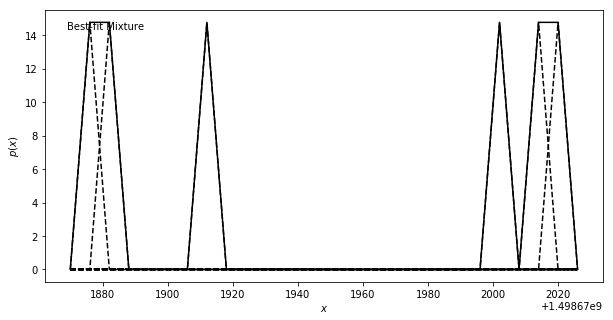

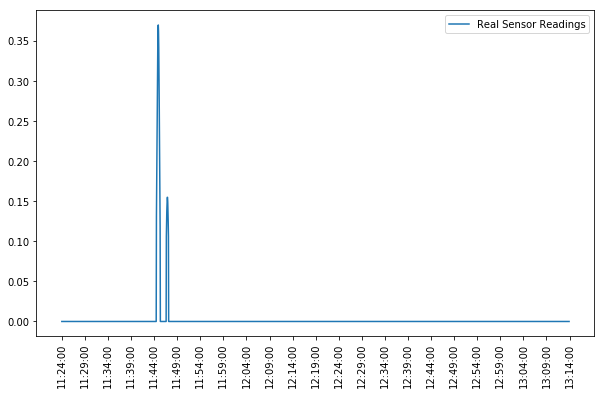

GT
[0.00205053 0.00228662 0.00253901 0.00280724 0.00309057 0.00338799
 0.00369819 0.00401958 0.00435026 0.00468808 0.00503058 0.00537509
 0.00571869 0.00605832 0.00639075 0.00671267 0.00702074 0.00731164
 0.00758211 0.00782906 0.00804959 0.00824103 0.00840104 0.00852764
 0.00861924 0.00867467 0.00869322 0.00867467 0.00861924 0.00852764
 0.00840104 0.00824103 0.00804959 0.00782906 0.00758211 0.00731164
 0.00702074 0.00671267 0.00639075 0.00605832 0.00571869 0.00537509
 0.00503058 0.00468808 0.00435026 0.00401958 0.00369819 0.00338799
 0.00309057 0.00280724 0.00253901 0.00228662 0.00205053]


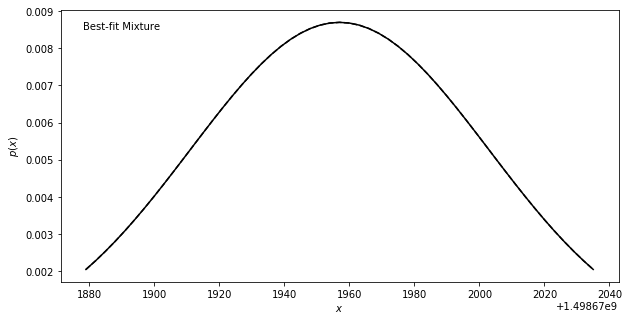

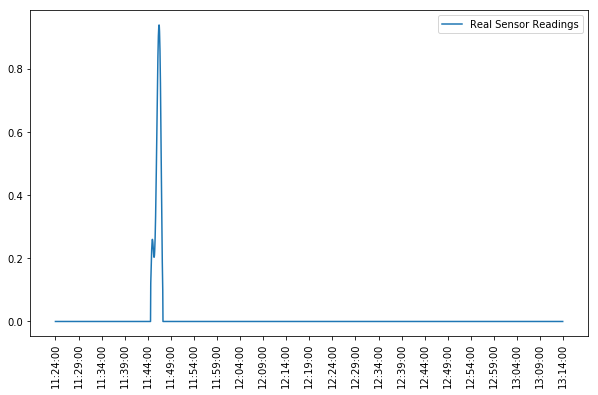

GT
[3.66743456e-003 7.31316021e-009 2.19007714e-035 9.84975315e-083
 6.65277067e-151 6.74826373e-240 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 1.15627319e-317 1.93119394e-257
 1.33718235e-203 3.83843779e-156 4.56790655e-115 2.25361325e-080
 4.60936068e-052 3.90841777e-030 1.37391729e-014 2.00225472e-005
 1.20969865e-002 3.02994147e-006 3.14622958e-016 1.35439638e-032
 2.41713127e-055 1.78835586e-084 5.48538133e-120 6.97523282e-162
 3.67713624e-210 8.03637716e-265 0.00000000e+000 2.38692105e-299
 1.43054234e-188 1.45955582e-103 2.53511434e-044 7.49602607e-011
 3.77330434e-003]


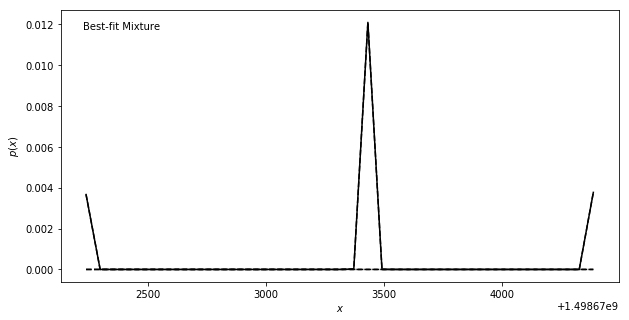

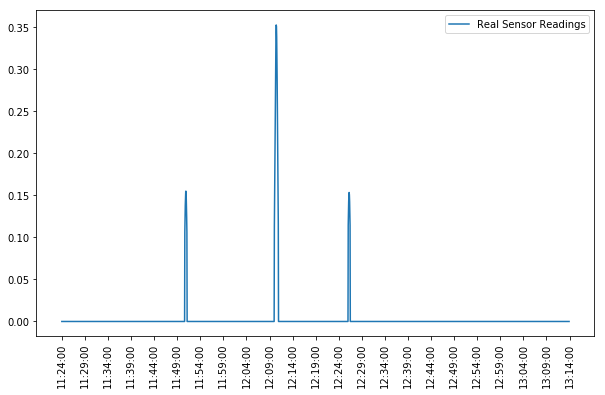

GT
[3.96040119e-04 4.23372739e-04 4.51763327e-04 4.81175787e-04
 5.11565952e-04 5.42881416e-04 5.75061437e-04 6.08036890e-04
 6.41730337e-04 6.76056156e-04 7.10920749e-04 7.46222866e-04
 7.81854011e-04 8.17698930e-04 8.53636187e-04 8.89538857e-04
 9.25275262e-04 9.60709824e-04 9.95703976e-04 1.03011714e-03
 1.06380777e-03 1.09663443e-03 1.12845693e-03 1.15913750e-03
 1.18854191e-03 1.21654073e-03 1.24301040e-03 1.26783444e-03
 1.29090452e-03 1.31212155e-03 1.33139665e-03 1.34865204e-03
 1.36382194e-03 1.37685326e-03 1.38770622e-03 1.39635489e-03
 1.40278755e-03 1.40700698e-03 1.40903054e-03 1.40889022e-03
 1.40663245e-03 1.40231782e-03 1.39602070e-03 1.38782865e-03
 1.37784179e-03 1.36617200e-03 1.35294201e-03 1.33828445e-03
 1.32234072e-03 1.30525988e-03 1.28719740e-03 1.26831392e-03
 1.24877391e-03 1.22874433e-03 1.20839336e-03 1.18788897e-03
 1.16739766e-03 1.14708314e-03 1.12710508e-03 1.10761794e-03
 1.08876976e-03 1.07070119e-03 1.05354443e-03 1.03742234e-03
 1.02244769e-03 1.008

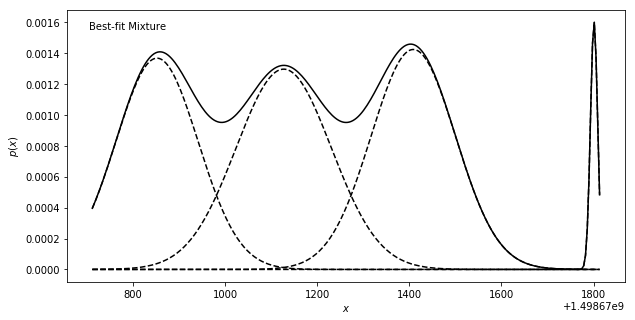

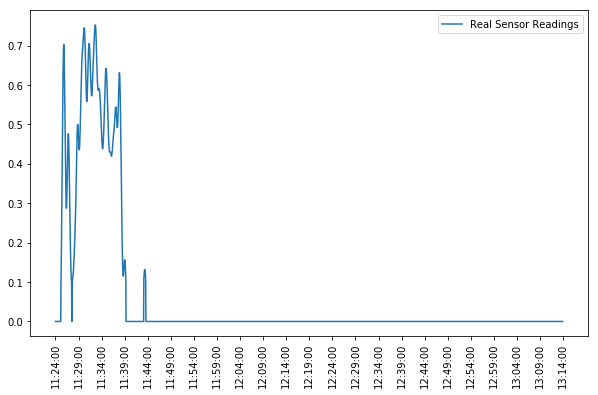

GT


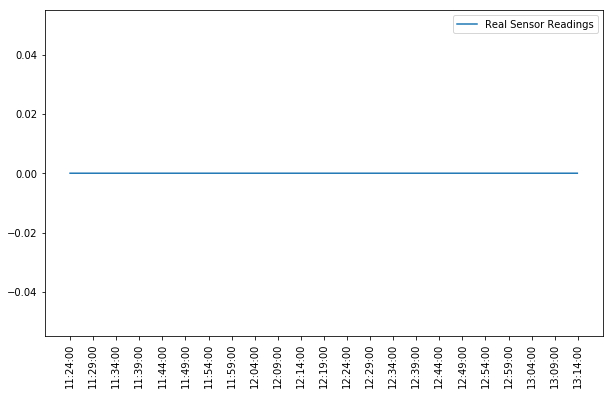

GT
[9.12498476e-004 2.77676651e-004 7.36332469e-011 1.70151559e-023
 3.42629939e-042 6.01231988e-067 9.19361348e-098 1.22506124e-134
 1.42251465e-177 1.43940528e-226 1.26922113e-281 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 8.51970071e-290 1.42495751e-250
 3.10151036e-214 8.78493850e-181 3.23815770e-150 1.55328590e-122
 9.69613115e-098 7.87661643e-076 8.32673790e-057 1.14552391e-040
 2.05081887e-027 4.77798172e-017 1.44862367e-009 5.71558475e-005
 2.93467295e-003 1.96088767e-004 1.70506014e-008 1.92939288e-015
 2.84115913e-025 5.444

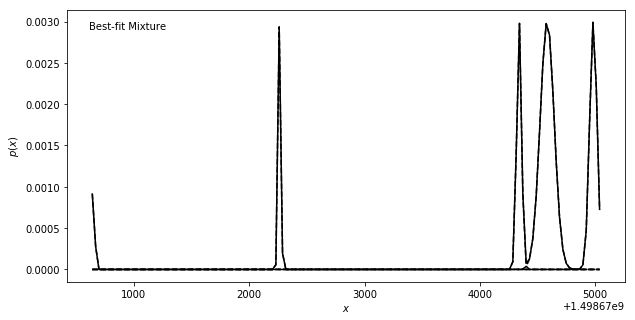

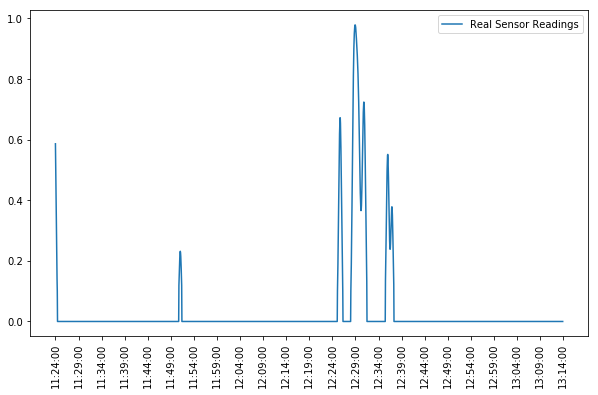

GT
[6.37569113e-004 1.01078801e-003 1.40963036e-006 1.72926958e-012
 1.86608999e-021 1.77139203e-033 1.47914000e-048 1.08646573e-066
 7.01997142e-088 3.98994345e-112 1.99485240e-139 8.77337738e-170
 3.39418533e-203 1.15509111e-239 3.45788194e-279 9.09080788e-322
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 2.86558075e-322 3.58191152e-315 7.24126571e-308 1.85833017e-300
 4.38221229e-293 8.56579427e-286 1.35849838e-278 1.74091624e-271
 1.80124510e-264 1.50443351e-257 1.01429250e-250 5.52001686e-244
 2.42495514e-237 8.59909903e-231 2.46143280e-224 5.68733758e-218
 1.06075676e-211 1.59701353e-205 1.94082851e-199 1.90393363e-193
 1.50765556e-187 9.63692414e-182 4.97233676e-176 2.07094517e-170
 6.96245593e-165 1.88947995e-159 4.13911978e-154 7.32029065e-149
 2.36615917e-142 1.89376210e-132 6.80167593e-123 1.04786539e-113
 6.92457675e-105 1.96281597e-096 2.38651626e-088 1.24465125e-080
 2.78438519e-073 2.67183508e-066 1.09973546e-059 1.94162513e-053
 1.47041898e-047 4.776

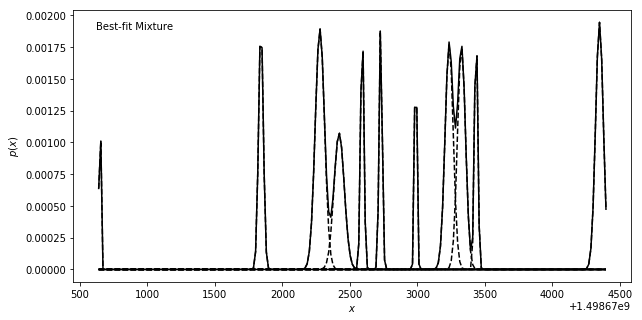

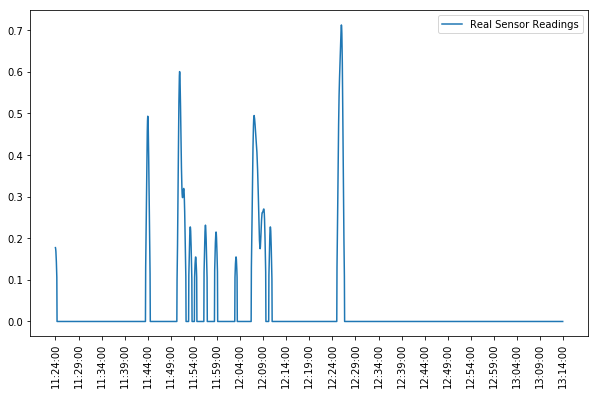

GT


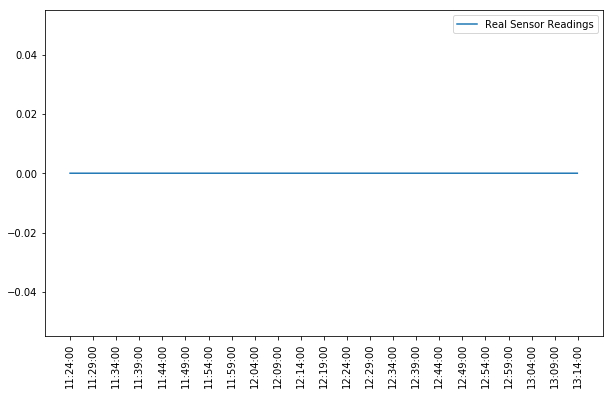

In [292]:


CreateUltilmateDataset()
PrintingData(df_)

In [ ]:
img = plt.imread("Data//sc.png")

for sensor in sensors_list:
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow(img, extent=[0, 6, 0, 10])
    plt.gca().invert_yaxis()
    pp = ax.plot(int(sensor.x) / 100, int(sensor.y) / 100 , marker='*', color='r', lw=5)

    for i in range(0, len(sensed_areas[str(sensor.sensor_id)])):
        pp = ax.plot(sensed_areas[str(sensor.sensor_id)][i][0], sensed_areas[str(sensor.sensor_id)][i][1], marker='.', color='k', lw=5)

    # print(sensed_areas[str(key)])
    plt.figure(figsize=(10,6))
    print(str(sensor.sensor_id))
    plt.show()


    # ax.cla()
    fig.canvas.draw()

In [ ]:
sensed_areas

In [ ]:
sensors_list


In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)

In [ ]:
from random import shuffle
x = [i for i in range(8)]
shuffle(x)
print(x)

In [ ]:
RestartVariables()